# Predicting Log Error
#### Xavier Carter (JUN 2021)


##### Project scope 
- The overall goal of the project was to predict logerror in the zillow dataset. 
- logerror is the log(zillow zestimate) - log(Actual Market Price)

##### Project Takeaways
- Clustering allows you to group things in a way that may be useful when creating models.
- By attempting to predict the log error cluster each house would fall in, I could potentially make our model stronger when running regression models.
- went with a strategy to only predict log error when log error occurs as opposed to trying to predict log error from the dataframe as a whole
- My second degree polynomial regression model was able to beat the baseline , validate was overfit. test was not.

In [1]:
import pandas as pd
import numpy as np
from PythonFunctions import wrangle, scale, explore, cluster, evaluate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

## Wrangle 
- used a sql query to bring the data over for single unit households with a transactiondate of 2017
- dropped any columns that we missing 30% or more rows
- dropped any rows that were missing 70% or more of there columns
- dropped the remaining nulls

In [2]:
zillow = wrangle.get_all_zillow_data()
zillow = zillow.sort_values('transactiondate').drop_duplicates('parcelid',keep='last')

In [3]:
zillow.shape

(77381, 69)

In [4]:
col, row = wrangle.get_nulls(zillow)

<class 'pandas.core.series.Series'>


In [5]:
#drop any col missing 30% of its data
zillow = wrangle.drop_null_columns(zillow,30)

<class 'pandas.core.series.Series'>


In [6]:
#drop any row missing 70% of its data
zillow = wrangle.drop_null_rows(zillow, 70)

In [7]:
#drop remaining data
zillow = zillow.dropna()
zillow = zillow.reset_index(drop=True)

In [8]:
zillow.isna().sum().sum()

0

In [9]:
zillow.shape

(64065, 30)

### Feature Engineering 
- extracted month from transactiondate
- created tax rate based on taxdollarvaluecnt and tax amount
- converted taxdollarvaluecnt to a logbase10 float
- added columns for closest city to the house and distance from said city (originally in miles)

In [10]:
zillow = wrangle.zillow_engineering(zillow)

In [11]:
zillow = wrangle.get_city_and_distance(zillow)

### Split/Scale
- split and scale using a minmax scaler

In [12]:
train ,validate, test = wrangle.split_for_model(zillow)
train_scaled, validate_scaled, test_scaled = scale.scale_data(train, validate, test, 'MinMax',\
                                                              to_scale=['log10price','calculatedfinishedsquarefeet','latitude','longitude',\
                                                                        'lotsizesquarefeet', 'yearbuilt','structuretaxvaluedollarcnt',\
                                                                        'taxvaluedollarcnt', 'taxamount', 'landtaxvaluedollarcnt','taxrate','finishedsquarefeet12', 'distancefromcity'])

train(35876, 35),validate(15376, 35),test(12813, 35)


## Explore

### Exploring Variables in relation to Target = Log Error

In [13]:
cont_vars = ['logerror','log10price','calculatedfinishedsquarefeet','latitude','longitude','lotsizesquarefeet', 'yearbuilt','structuretaxvaluedollarcnt',\
             'taxvaluedollarcnt', 'taxamount', 'landtaxvaluedollarcnt','taxrate','finishedsquarefeet12', 'transactionmonth','bathroomcnt','bedroomcnt' , 'regionidzip', 'distancefromcity']
target = 'logerror'

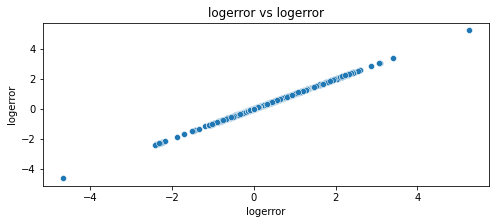

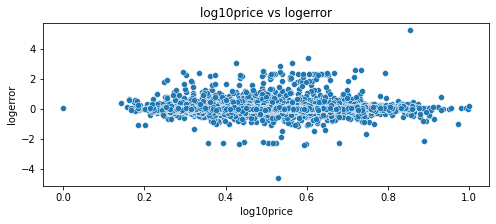

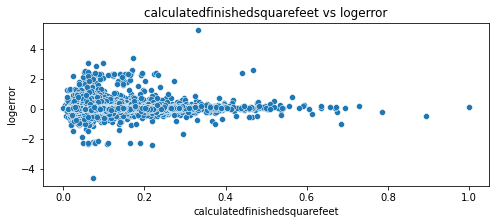

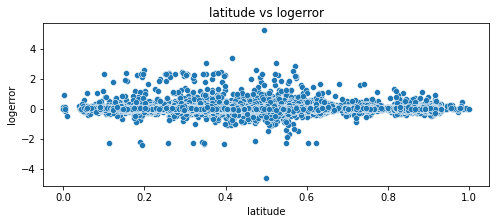

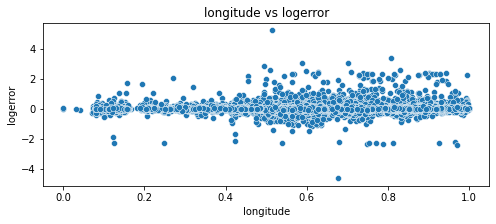

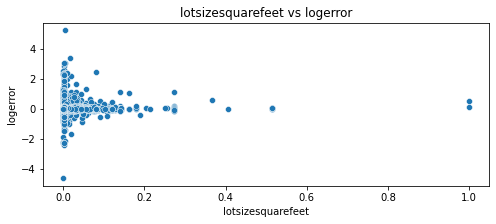

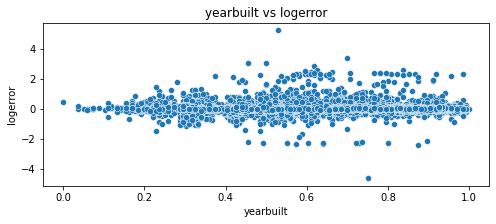

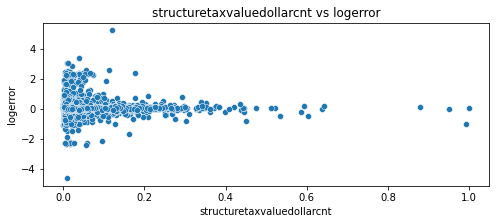

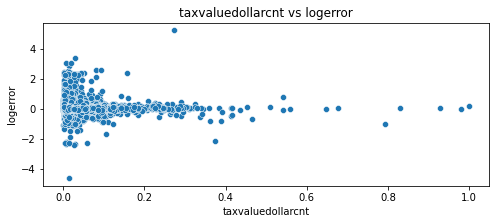

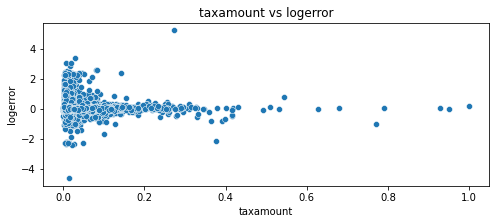

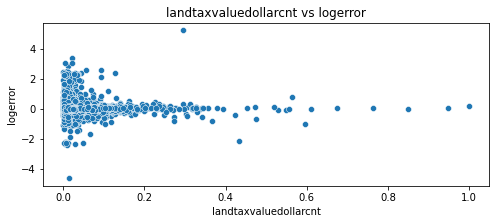

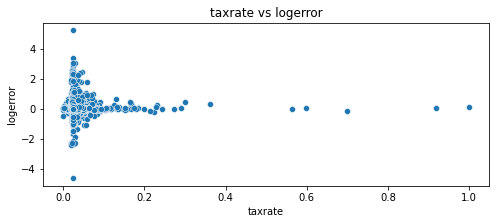

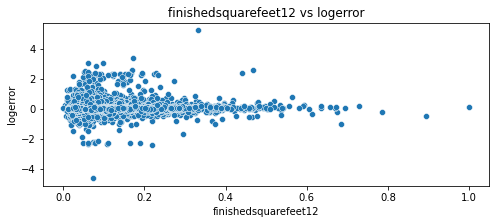

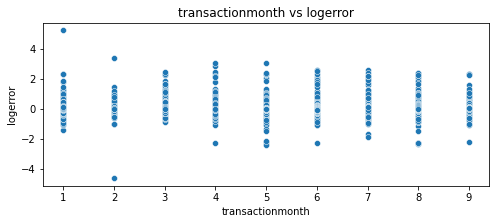

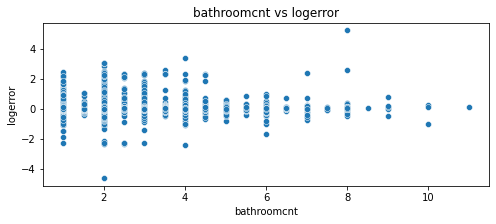

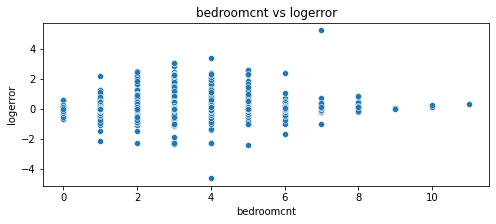

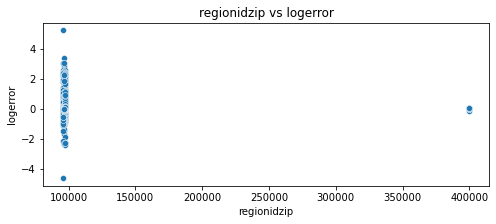

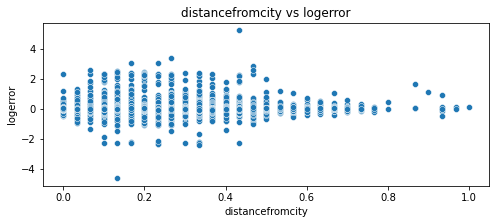

In [14]:
explore.compare_to_target(train_scaled[cont_vars], target)

## Take Aways
- Pricing, Size, Age, and Location play  big rolls in log error
- The more houses are similar to eachother in terms of these 4 main topics , the more log error seems to be
- we will look more into age vs price vs size vs location , cluster these and see if we can spot trends on log error

## Clustering 
### Target = Logerror 

In [15]:
X = train_scaled[['logerror']]
X = cluster.show_cluster(X, 4, 'logbin', hide=True)
train_scaled['logbin'] = X['logbin']

### Price

In [16]:
X = train_scaled[['taxvaluedollarcnt','structuretaxvaluedollarcnt','taxamount']]
X = cluster.show_cluster(X, 4, 'price', hide=True)
train_scaled['price'] = X['price']

### Size

In [17]:
X = train_scaled[['calculatedfinishedsquarefeet','finishedsquarefeet12','lotsizesquarefeet']]
X = cluster.show_cluster(X, 4, 'size', hide= True)
train_scaled['size'] = X['size']

### Age

In [18]:
X = train_scaled[['yearbuilt']]
X = cluster.show_cluster(X, 4, 'age', hide=True)
train_scaled['age'] = X['age']

### Location

In [19]:
X = train_scaled[['distancefromcity']]
X = cluster.show_cluster(X, 5, 'distance', hide=True)
train_scaled['distance'] = X['distance']

## Cross Referencing our Big 4

### Size vs Price

In [20]:
X = train_scaled[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt']]
X = cluster.show_cluster(X, 4, 'svp',hide=True)
train_scaled['svp'] = X['svp']

### Price vs Age

In [21]:
X = train_scaled[['taxvaluedollarcnt', 'yearbuilt']]
X = cluster.show_cluster(X, 4, 'pva', hide=True)
train_scaled['pva'] = X['pva']


### Age vs Size

In [22]:
X = train_scaled[[ 'yearbuilt', 'calculatedfinishedsquarefeet']]
X = cluster.show_cluster(X, 4, 'avs', hide=True)
train_scaled['avs'] = X['avs']

### Size vs Distance

In [23]:
X = train_scaled[['calculatedfinishedsquarefeet','distancefromcity']]
X = cluster.show_cluster(X, 4, 'svd', hide=True)
train_scaled['svd'] = X['svd']

### Price vs Distance

In [24]:
X = train_scaled[['taxvaluedollarcnt','distancefromcity']]
X = cluster.show_cluster(X, 4, 'pvd', hide=True)
train_scaled['pvd'] = X['pvd']

### Age vs Distance

In [25]:
X = train_scaled[['yearbuilt','distancefromcity']]
X = cluster.show_cluster(X, 4, 'avd', hide=True)
train_scaled['avd'] = X['avd']

## All 4

### Size vs Price vs Age vs Location

In [26]:
X = train_scaled[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'yearbuilt', 'distancefromcity']]
X = cluster.show_cluster(X, 4, 'all', 'yearbuilt', hide=True)
train_scaled['all'] = X['all']

### Find Trend

In [27]:
X = train_scaled[['logerror']]
X = cluster.show_cluster(X, 4, 'logbin',hide= True)
train_scaled['logbin'] = X['logbin']

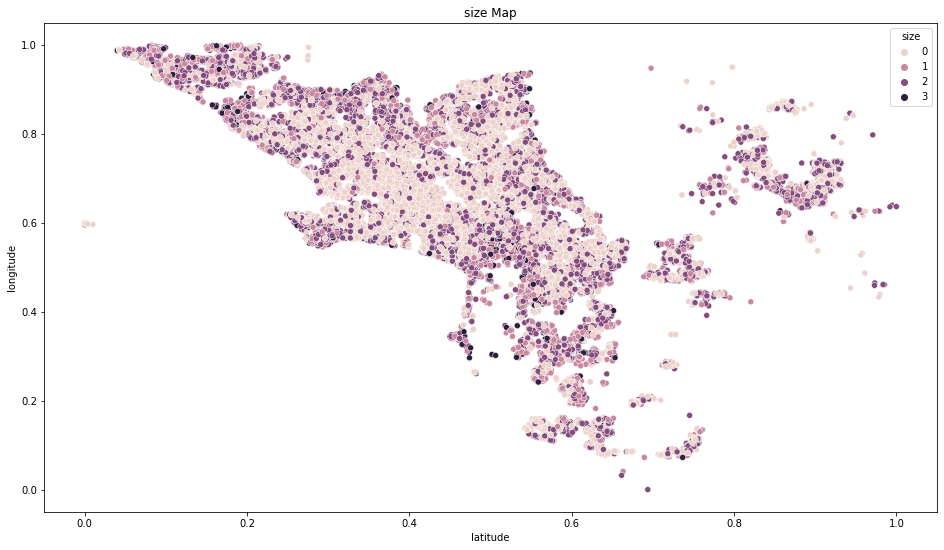

In [80]:
cluster.map_clusters(train_scaled, 'size')
#cluster.map_clusters(train_scaled[(train_scaled['logbin'] == 3) |(train_scaled['logbin'] == 2) ], 'price')

## Major Takeaway 
- Majority of the houses that had the most log error are either cheaper , smaller, or closer to a major city
- At the same time, There are more cheaper and smaller houses in the dataset that fell into the cluster into no error, meaning theres almost no error, how can we make sure our model only focuses on houses  that actually have logerror? answer:filter by log cluster 

## Statistical Testing for clusters
- Here we'll check to see if the clusters created have any statistical value
- Clusters are discrete variables, we'll run a T-test to see if there related to log error
- Since we'll be using these variables to predict What logbin each house falls, we'll run a chi2 to check correlation to logbin as well

In [29]:
cols= ['price','size','age','distance','svp','pva','avs','svd', 'pvd','avd']
evaluate.get_t_test(cols, train_scaled, 'logerror', .05)

Null Hypothesis: price has no correlation to logerror
Alternative hypothesis:  price has correlation to logerror 
p value 0.0 is less than alpha 0.05 , we reject our null hypothesis
-------------------------------------
Null Hypothesis: size has no correlation to logerror
Alternative hypothesis:  size has correlation to logerror 
p value 0.0 is less than alpha 0.05 , we reject our null hypothesis
-------------------------------------
Null Hypothesis: age has no correlation to logerror
Alternative hypothesis:  age has correlation to logerror 
p value 0.0 is less than alpha 0.05 , we reject our null hypothesis
-------------------------------------
Null Hypothesis: distance has no correlation to logerror
Alternative hypothesis:  distance has correlation to logerror 
p value 0.0 is less than alpha 0.05 , we reject our null hypothesis
-------------------------------------
Null Hypothesis: svp has no correlation to logerror
Alternative hypothesis:  svp has correlation to logerror 
p value 0.

In [30]:
evaluate.get_chi_test(cols,train_scaled,0.05,'logbin')

logbin      0     1    2   3
price                       
0       25754  1465  319  74
1        6743   270  127  30
2          68    12   12   1
3         874    83   40   4
Null Hyothesis: price and logbin are independent to eachother
Alternative hypothesis: price and logbin have dependency to one another
p value 2.251842022905115e-44 is less than alpha 0.05 , we reject our null hypothesis
-------------------------------------
logbin      0     1    2   3
size                        
0       17690  1014  265  49
1        3995   256   82  28
2       11317   497  127  28
3         437    63   24   4
Null Hyothesis: size and logbin are independent to eachother
Alternative hypothesis: size and logbin have dependency to one another
p value 9.747365419550532e-31 is less than alpha 0.05 , we reject our null hypothesis
-------------------------------------
logbin      0    1    2   3
age                        
0        3789  350  159  14
1       10020  417   93  27
2       12726  804  189  4

### Takeaways
-  Going forward, all clusters can reject our hypothesis when looking at a continous target loggeror
-  All clusters except for distance, price vs distance(pvd) and size vs distance(svd) were able to reject or null hypothesis, using these 3 might not have any statistical backing if used while running classification model.

### Next steps
- We only know logbin due to knowing logerror, so we cant use it to model, but we can attempt to predict what log error cluster a house might fall into

##### add clusters to validate and test dataframes

In [31]:
#---Validate---
X = validate_scaled[['logerror']]
X = cluster.show_cluster(X, 4, 'logbin', hide=True)
validate_scaled['logbin'] = X['logbin']

X = validate_scaled[['taxvaluedollarcnt']]
X = cluster.show_cluster(X, 4, 'price',hide= True)
validate_scaled['price'] = X['price']

X = validate_scaled[['calculatedfinishedsquarefeet']]
X = cluster.show_cluster(X, 4, 'size',hide= True)
validate_scaled['size'] = X['size']

X = validate_scaled[['yearbuilt']]
X = cluster.show_cluster(X, 4, 'age',hide= True)
validate_scaled['age'] = X['age']

X = validate_scaled[['distancefromcity']]
X = cluster.show_cluster(X, 4, 'distance', hide=True)
validate_scaled['distance'] = X['distance']

X = validate_scaled[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt']]
X = cluster.show_cluster(X, 4, 'svp',hide= True)
validate_scaled['svp'] = X['svp']

X = validate_scaled[['taxvaluedollarcnt', 'yearbuilt']]
X = cluster.show_cluster(X, 4, 'pva',hide= True)
validate_scaled['pva'] = X['pva']

X = validate_scaled[[ 'yearbuilt', 'calculatedfinishedsquarefeet']]
X = cluster.show_cluster(X, 4, 'avs',hide= True)
validate_scaled['avs'] = X['avs']

X = validate_scaled[['calculatedfinishedsquarefeet','distancefromcity']]
X = cluster.show_cluster(X, 4, 'svd', hide=True)
validate_scaled['svd'] = X['svd']

X = validate_scaled[['taxvaluedollarcnt','distancefromcity']]
X = cluster.show_cluster(X, 4, 'pvd', hide=True)
validate_scaled['pvd'] = X['pvd']

X = validate_scaled[['yearbuilt','distancefromcity']]
X = cluster.show_cluster(X, 4, 'avd', hide=True)
validate_scaled['avd'] = X['avd']

X = validate_scaled[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'yearbuilt', 'distancefromcity']]
X = cluster.show_cluster(X, 4, 'all', 'yearbuilt', hide=True)
validate_scaled['all'] = X['all']


In [32]:
#---Test---
X = test_scaled[['logerror']]
X = cluster.show_cluster(X, 4, 'logbin', hide=True)
test_scaled['logbin'] = X['logbin']

X = test_scaled[['taxvaluedollarcnt']]
X = cluster.show_cluster(X, 4, 'price',hide= True)
test_scaled['price'] = X['price']

X = test_scaled[['calculatedfinishedsquarefeet']]
X = cluster.show_cluster(X, 4, 'size',hide= True)
test_scaled['size'] = X['size']

X = test_scaled[['yearbuilt']]
X = cluster.show_cluster(X, 4, 'age',hide= True)
test_scaled['age'] = X['age']

X = test_scaled[['distancefromcity']]
X = cluster.show_cluster(X, 4, 'distance', hide=True)
test_scaled['distance'] = X['distance']

X = test_scaled[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt']]
X = cluster.show_cluster(X, 4, 'svp',hide= True)
test_scaled['svp'] = X['svp']

X = test_scaled[['taxvaluedollarcnt', 'yearbuilt']]
X = cluster.show_cluster(X, 4, 'pva',hide= True)
test_scaled['pva'] = X['pva']

X = test_scaled[[ 'yearbuilt', 'calculatedfinishedsquarefeet']]
X = cluster.show_cluster(X, 4, 'avs',hide= True)
test_scaled['avs'] = X['avs']

X = test_scaled[['calculatedfinishedsquarefeet','distancefromcity']]
X = cluster.show_cluster(X, 4, 'svd', hide=True)
test_scaled['svd'] = X['svd']

X = test_scaled[['taxvaluedollarcnt','distancefromcity']]
X = cluster.show_cluster(X, 4, 'pvd', hide=True)
test_scaled['pvd'] = X['pvd']

X = test_scaled[['yearbuilt','distancefromcity']]
X = cluster.show_cluster(X, 4, 'avd', hide=True)
test_scaled['avd'] = X['avd']

X = test_scaled[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'yearbuilt', 'distancefromcity']]
X = cluster.show_cluster(X, 4, 'all', 'yearbuilt', hide=True)
test_scaled['all'] = X['all']

##### drop non-numerical columns and id columns for modeling

In [33]:
train_scaled = train_scaled.drop(columns=['propertylandusetypeid','parcelid','id','id.1',\
                                          'transactiondate','propertycountylandusecode',\
                                          'propertylandusedesc'])
validate_scaled = validate_scaled.drop(columns=['propertylandusetypeid','parcelid','id','id.1',\
                                          'transactiondate','propertycountylandusecode',\
                                          'propertylandusedesc'])
test_scaled = test_scaled.drop(columns=['propertylandusetypeid','parcelid','id','id.1',\
                                          'transactiondate','propertycountylandusecode',\
                                          'propertylandusedesc'])

### 1. Predict Log Cluster
- No logerror = no correlation

In [34]:
# 30,000 houses have virtually no logerror, which skews correlation when looking at the entire dataset
train_scaled.logbin.value_counts()

0    33439
1     1830
2      498
3      109
Name: logbin, dtype: int64

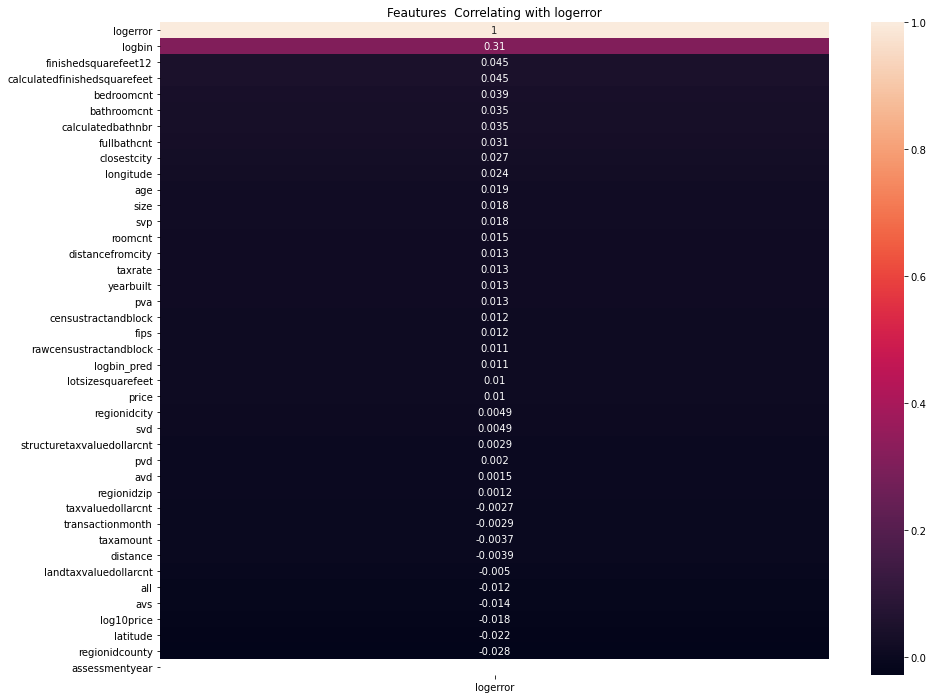

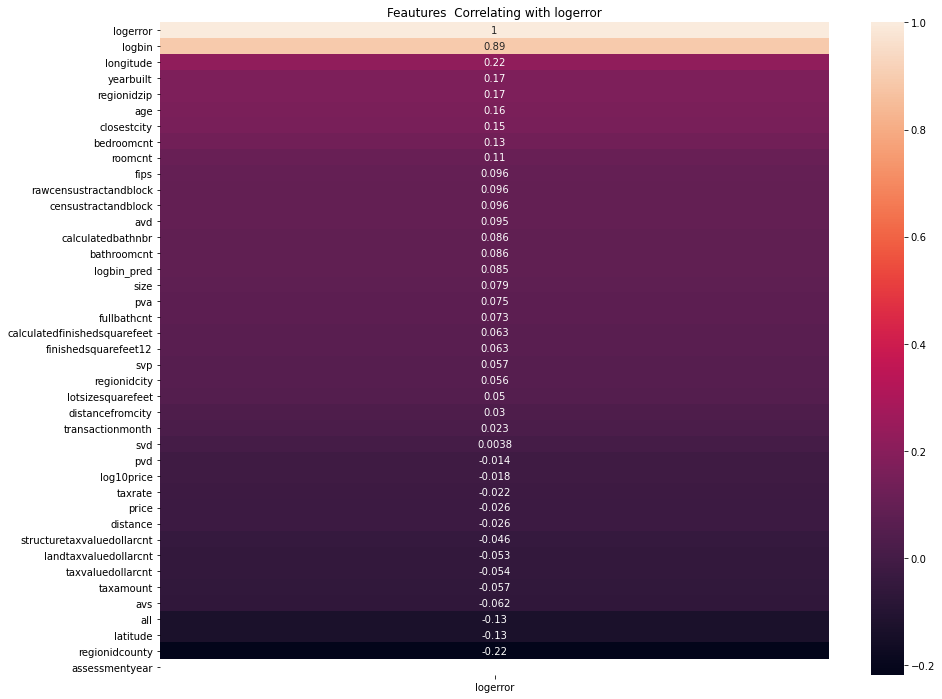

<AxesSubplot:title={'center':'Feautures  Correlating with logerror'}>

In [73]:
explore.get_heatmap(train_scaled, 'logerror')
explore.get_heatmap(train_scaled[(train_scaled['logbin'] > 1)], 'logerror')

#### Drivers for classification

In [37]:
X_train = train_scaled[(train_scaled['logbin'] > 1)].drop(columns=['logerror','logbin'])
y_train = train_scaled[(train_scaled['logbin'] > 1)].logbin

X_validate = validate_scaled[(validate_scaled['logbin'] > 1)].drop(columns=['logerror','logbin'])
y_validate = validate_scaled[(validate_scaled['logbin'] > 1)].logbin

X_test = test_scaled[(test_scaled['logbin'] > 1)].drop(columns=['logerror','logbin'])
y_test = test_scaled[(test_scaled['logbin'] > 1)].logbin

y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

#### Best from RFE
- we'll look at what RFE picks vs what i pick and see which drivers preform better

In [38]:
my_pick = ['regionidcounty','latitude','longitude','age','closestcity','regionidzip','roomcnt']
rfe = evaluate.select_rfe(X_train, y_train, 7)

## Classification Modeling 


In [39]:
baseline = evaluate.get_baseline(train_scaled[(train_scaled['logbin'] > 1)], 'logbin')
base = evaluate.train_validate_results(baseline, X_train, y_train, X_validate, y_validate)

Train model Accuracy: 82.04283 % | Validate model accuracy: 7.01403 % 


### Decision Tree

In [40]:
model = DecisionTreeClassifier(max_depth=50)
dt = evaluate.train_validate_results(model, X_train, y_train, X_validate, y_validate, rfe)

Train model Accuracy: 100.00000 % | Validate model accuracy: 19.03808 % 


### Random Forest 

In [41]:
model = RandomForestClassifier(max_depth=4, max_leaf_nodes= 50)
rf = evaluate.train_validate_results(model, X_train, y_train, X_validate, y_validate, rfe)

Train model Accuracy: 82.04283 % | Validate model accuracy: 7.01403 % 


### KNN 

In [42]:
model = KNeighborsClassifier(n_neighbors=10)
knn = evaluate.train_validate_results(model, X_train, y_train, X_validate, y_validate, rfe)

Train model Accuracy: 82.37232 % | Validate model accuracy: 8.61723 % 


### Test Random Forest

In [43]:
model = DecisionTreeClassifier(max_depth=50)
dtt = evaluate.test_results(model, X_test, y_test, X_train, y_train, rfe)

Test model Accuracy: 68.36879 %


### Add Predictions onto original data
- if the row was not predicted, the chances of it being from bin 0 is incredibly likely, so we'll fill with 0

In [44]:
train_scaled.loc[:,'logbin_pred'] = pd.Series(dt[0])
train_scaled['logbin_pred'] = train_scaled.logbin_pred.fillna(0)

validate_scaled.loc[:,'logbin_pred'] = pd.Series(dt[1])
validate_scaled['logbin_pred'] = validate_scaled.logbin_pred.fillna(0)

test_scaled.loc[:,'logbin_pred'] = pd.Series(dtt)
test_scaled['logbin_pred'] = test_scaled.logbin_pred.fillna(0)

In [45]:
X_train = train_scaled.drop(columns=['logerror','logbin'])
y_train = train_scaled[['logerror','logbin_pred']]

X_validate = validate_scaled.drop(columns=['logerror','logbin'])
y_validate = validate_scaled[['logerror','logbin_pred']]

X_test = test_scaled.drop(columns=['logerror','logbin'])
y_test = test_scaled[['logerror','logbin_pred']]

y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

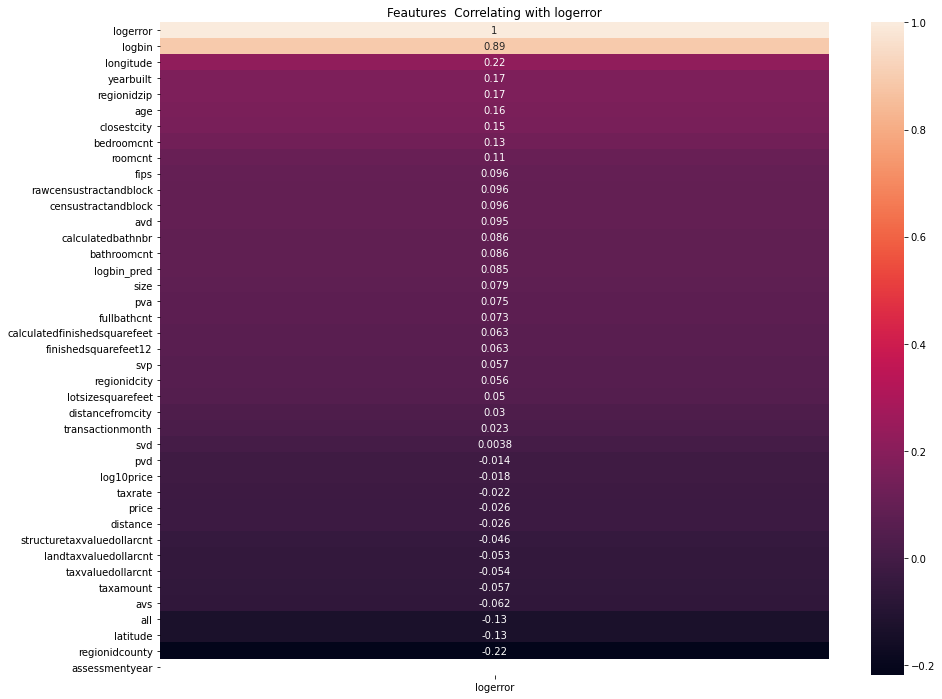

<AxesSubplot:title={'center':'Feautures  Correlating with logerror'}>

In [46]:
explore.get_heatmap(train_scaled[train_scaled['logbin'] > 1], 'logerror')

In [47]:
cols = ['logbin_pred']
evaluate.get_t_test(cols, train_scaled, 'logerror', .05)

Null Hypothesis: logbin_pred has no correlation to logerror
Alternative hypothesis:  logbin_pred has correlation to logerror 
p value 0.002520889218838372 is less than alpha 0.05 , we reject our null hypothesis
-------------------------------------


## Regression Modeling 
- Next we will run regression models on data with actual log error, then avg it with the non-preidicted baseline to see if it beats the baseline.
- Since we only want to predict log error when log orrer occurs, we'll use the baseline for everything we did not predict
- RMSE((not_predicted_baseline + predicted_values)/2) < RMSE Baseline than baseline.

In [48]:
rfe = evaluate.select_rfe(X_train[X_train['logbin_pred'] > 1], evaluate.get_logbin(y_train,1), 10)

In [49]:
target = 'logerror'

In [50]:
Baseline = evaluate.baseline_errors(y_train.logerror)[2]
Baseline

0.16750693058640187

In [51]:
#get baseline rmse for everything not predicted
baseline_up = evaluate.baseline_errors(train_scaled[train_scaled['logbin'] < 2].logerror)[2]
baseline_up

0.1017803521730797

### OLS Linear Regression Model

In [52]:
## train
lm_train = evaluate.get_model_results(evaluate.get_logbin(X_train[rfe], 1),\
                                      evaluate.get_logbin(y_train, 1).logerror,\
                                      evaluate.get_logbin(X_train[rfe], 1),\
                                      evaluate.get_logbin(y_train, 1), target)

r2 Score:  0.4834416956995395
RMSE Score: 0.23467394828114757


In [53]:
#better than baseline
(lm_train[1] + baseline_up)/2 < Baseline

False

### Lasso Lars 

In [76]:
#train
ll_train = evaluate.get_model_results(evaluate.get_logbin(X_train[rfe], 1),\
                                      evaluate.get_logbin(y_train, 1).logerror,\
                                      evaluate.get_logbin(X_train[rfe], 1),\
                                      evaluate.get_logbin(y_train, 1), target, 'lasso')

r2 Score:  0.44675358728125797
RMSE Score: 0.24464820569922036


In [55]:
#better than baseline
(ll_train[1] + baseline_up)/2 < Baseline

False

### 2nd degree polynomial

r2 Score:  0.7572052694545884
RMSE Score: 0.16513814711562294


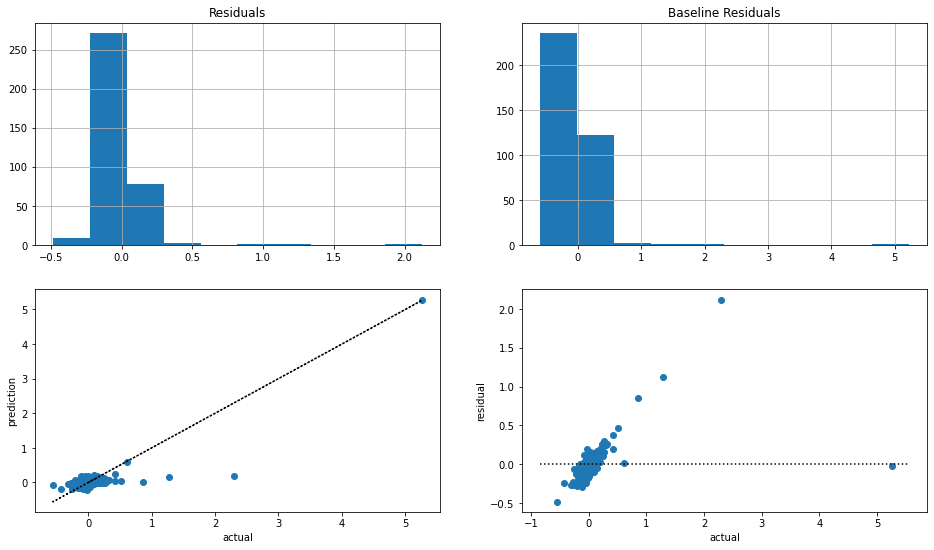

In [56]:
#train
pl_train = evaluate.get_model_results(evaluate.get_logbin(X_train[rfe], 1),\
                                      evaluate.get_logbin(y_train, 1).logerror,\
                                      evaluate.get_logbin(X_train[rfe], 1),\
                                      evaluate.get_logbin(y_train, 1), target, 'poly', graph= True)

In [57]:
#better than baseline
(pl_train[1] + baseline_up)/2 < Baseline

True

r2 Score:  0.3836342489329152
RMSE Score: 0.27662995792611295


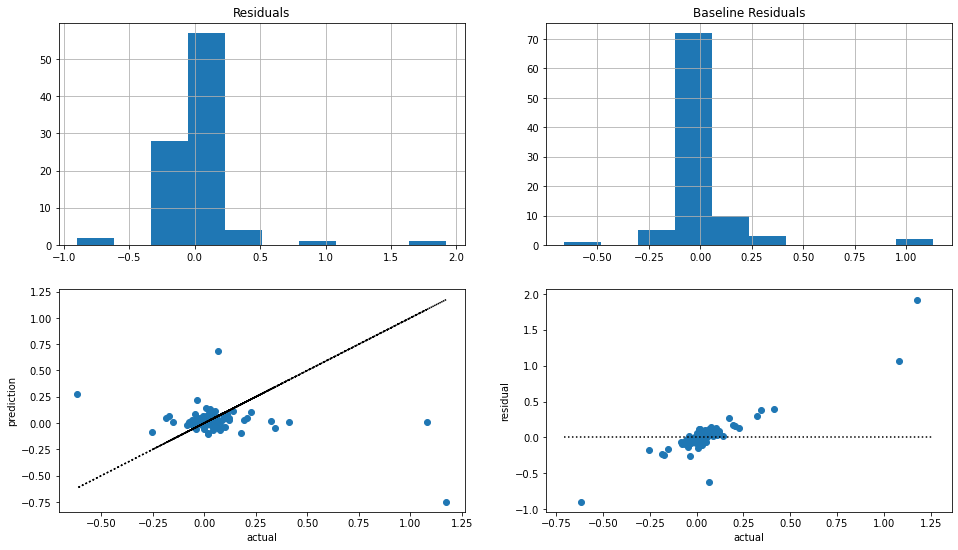

In [77]:
#Validate
pl_validate = evaluate.get_model_results(evaluate.get_logbin(X_train[rfe], 1),\
                                      evaluate.get_logbin(y_train, 1).logerror,\
                                      evaluate.get_logbin(X_validate[rfe], 1),\
                                      evaluate.get_logbin(y_validate, 1), target, 'poly', graph=True)

In [59]:
(pl_validate[1] + baseline_up)/2 < Baseline

False

r2 Score:  1.0616512507304985
RMSE Score: 0.16889497331905287


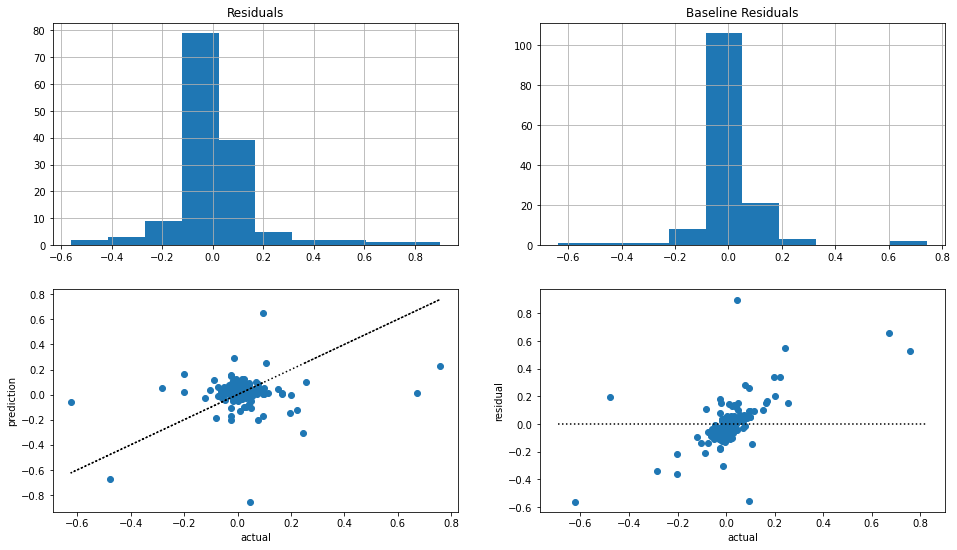

In [78]:
#Run test for fun
pl_test = evaluate.get_model_results(evaluate.get_logbin(X_train[rfe], 1),\
                                      evaluate.get_logbin(y_train, 1).logerror,\
                                      evaluate.get_logbin(X_test[rfe], 1),\
                                      evaluate.get_logbin(y_test, 1), target, 'poly', graph=True)

In [61]:
(pl_test[1] + baseline_up)/2 < Baseline

True

## In conclusion
- The regression models were not able to beat all the test cases.
- It seems that since I narrowed down my datasets to a point where there wasnt much left to validate and test on, It skews my models, making them overfit
- Key to project may be finding a balance in creating more flexible models and clusters
- With More time
    * go back to prepare, revisit removal of nulls and outliers
    * I would like to finding accurate and look at more models both in and out of the scope of the curriculum to see how they run
    * Explore more trends via clustering
    * Utilize log error more in actual clustering as opposed to only using it as a visual tool.
